In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn
import sklearn

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split
from WAtt.utils import *

plt.style.use("../science.mplstyle")

The notebook aims to showcase the results for our experiments using Wireline Attention (WAtt). It consists of five integral sections:

1. The [DTS Section](#dts) prepares the input data for the fine-tuning task1: shear slowness (DTS) wireline prediction.

2. The [Facies Section](#facies) prepares the input data for the fine-tuning task2: facies prediction.

3. The [Exports Section](#exports) export the corresponding input data.

4. The [Pre-training](#pretrain) showcases results from the pre-training stage of the WAtt.

5. The [Fine-tuning](#fine_tune) showcases results from the fine-tuning stage of the WAtt.

    5.1 [DTS Prediction](#dts_pred) shows result for the DTS prediction.

    5.2 [Zero-shot DTS Prediction](#zero_shot) shows result for the zero-shot DTS prediction.

    5.4 [Facies Prediction](#facies_pred) shows result for the facies prediction.


<c id='dts'></c>
# DTS

In [ ]:
# Load the training data
train_data = pd.read_csv('../../../labs/data/train.csv', sep=';')
train_data['WELL'] = train_data['WELL'].astype('category').cat.codes

# Load the validing data
valid_data = pd.read_csv('../../../labs/data/leaderboard_test_features.csv', sep=';')
valid_data['WELL'] = valid_data['WELL'].astype('category').cat.codes

train_data = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()
valid_data = valid_data[~np.isnan(valid_data.DTS.values)][['WELL', 'DEPTH_MD','CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()

train_data['RDEP']=np.log(train_data.RDEP.values)
valid_data['RDEP']=np.log(valid_data.RDEP.values)

train_data['Type'] = 'Training'
valid_data['Type'] = 'Validation'

# sns.pairplot(train_data.append(valid_data).sample(1024 , axis=0), hue='Type')

train_data = train_data.mask(train_data>train_data.quantile(0.95), train_data.quantile(0.95), axis=1)
valid_data = valid_data.mask(valid_data>valid_data.quantile(0.95), valid_data.quantile(0.95), axis=1)

# sns.pairplot(train_data.append(valid_data).sample(1024 , axis=0), hue='Type')

transform = sklearn.preprocessing.MinMaxScaler()
df = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

transform = sklearn.preprocessing.MinMaxScaler()
df = valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)


# Select input
X_train = train_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_train = train_data[['DTS', 'WELL']].copy()

X_valid = valid_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_valid = valid_data[['DTS', 'WELL']].copy()

# Define Train Set
X_train = torch.from_numpy(X_train.to_numpy()).float().view(-1,X_train.shape[1])
y_train = torch.from_numpy(y_train.to_numpy()).float().view(-1,y_train.shape[1])
train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_valid = torch.from_numpy(X_valid.to_numpy()).float().view(-1,X_valid.shape[1])
y_valid = torch.from_numpy(y_valid.to_numpy()).float().view(-1,y_valid.shape[1])
valid_dataset = TensorDataset(X_valid, y_valid)

# Naive way to segment the wireline data based on specific sequence length
seq_len = 512
df_train = train_data[train_data['WELL']==7][:seq_len]
for i in np.unique(train_data.WELL.values):
    sz = len(train_data[train_data['WELL']==i])//seq_len
    for j in range(sz):
        df_train_seq = train_data[train_data['WELL']==i][j*seq_len:(j+1)*seq_len]
        df_train = df_train.append(df_train_seq, ignore_index=True)
    
    df_train = df_train.append(train_data[train_data['WELL']==i][-seq_len:], ignore_index=True)

df_valid = valid_data[valid_data['WELL']==1][:seq_len]
for i in np.unique(valid_data.WELL.values):
    sz = len(valid_data[valid_data['WELL']==i])//seq_len
    for j in range(sz):
        df_valid_seq = valid_data[valid_data['WELL']==i][j*seq_len:(j+1)*seq_len]
        df_valid = df_valid.append(df_valid_seq, ignore_index=True)
    
    df_valid = df_valid.append(valid_data[valid_data['WELL']==i][-seq_len:], ignore_index=True)

# Removing less than sequence length well
for i in np.unique(train_data.WELL.values):
    if len(df_train[df_train.WELL==i])%seq_len!=0:
        print(i, len(train_data[train_data.WELL==55]))
        df_train = df_train.drop(df_train[df_train.WELL==i].index)

# Dataset
train_dataset = WirelineDataset(df_train, 256, pred_type='DTS')
valid_dataset = WirelineDataset(df_valid, 256, pred_type='DTS')

# train_loader = DataLoader(train_dataset, batch_size=X_train.size(0), shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=X_valid.size(0), shuffle=False)

In [ ]:
train_data_input = pd.read_csv('../../../labs/data/train.csv', sep=';')
valid_data_input = pd.read_csv('../../../labs/data/leaderboard_test_features.csv', sep=';')

well = lasio.read('../data/21-31_WirelineLogs/Ormat_Forge_21-31_12.25inchsection/Ormat_Forge_21-31_12.25 inch section/Tripple Combo/LAS/DWM5-00038_Ormat Nevada_Forge 21-31_Pr_Composite1_Main_-GenericV12.las')
test_data_input = well.df()

import pymap3d as pm

import cartopy.crs as ccrs
plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.OCEAN)
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)
ax.set_global()
ax.coastlines()

# ax.set_extent([-90, 60, -40, 45], crs=ccrs.Robinson())
LAT, LON, ELEV = pm.ecef2geodetic(train_data_input['X_LOC'].values,train_data_input['Y_LOC'].values, -train_data_input['Z_LOC'].values)
plt.scatter(LAT, LON, color='y', s=300, marker='*',transform=ccrs.PlateCarree(), edgecolors='y',zorder=2)
LAT, LON, ELEV = pm.ecef2geodetic(valid_data_input['X_LOC'].values,valid_data_input['Y_LOC'].values, -valid_data_input['Z_LOC'].values)
plt.scatter(LAT, LON, color='b', s=300, marker='*',transform=ccrs.PlateCarree(), edgecolors='b',zorder=2)
plt.scatter(39.386616,-118.66657, color='r', s=300, marker='*',transform=ccrs.PlateCarree(), edgecolors='red',zorder=2)
# plt.savefig('map_with.png')

fig = plt.figure(figsize=(8,6), dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-100, 80, -10, 90], crs=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()
ax.scatter(39.386616,-118.66657, color='r', s=100, marker='*',transform=ccrs.PlateCarree(), edgecolors='red',zorder=2)
LAT, LON, ELEV = pm.ecef2geodetic(train_data_input['X_LOC'].values,train_data_input['Y_LOC'].values, train_data_input['Z_LOC'].values)
ax.scatter(LAT, LON, color='y', s=100, marker='*',transform=ccrs.PlateCarree(), edgecolors='y',zorder=2)
LAT, LON, ELEV = pm.ecef2geodetic(valid_data_input['X_LOC'].values,valid_data_input['Y_LOC'].values, -valid_data_input['Z_LOC'].values)
plt.scatter(LAT, LON, color='b', s=100, marker='*',transform=ccrs.PlateCarree(), edgecolors='b',zorder=2)
plt.savefig('map_with.png')

In [ ]:
fig = plt.figure(figsize=(8,6), dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-100, 80, -10, 90], crs=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()
ax.scatter(39.386616,-118.66657, color='r', s=100, marker='*',transform=ccrs.PlateCarree(), edgecolors='red',zorder=2)
LAT, LON, ELEV = pm.ecef2geodetic(train_data_input['X_LOC'].values,train_data_input['Y_LOC'].values, train_data_input['Z_LOC'].values)
ax.scatter(LAT, LON, color='y', s=100, marker='*',transform=ccrs.PlateCarree(), edgecolors='y',zorder=2)
LAT, LON, ELEV = pm.ecef2geodetic(valid_data_input['X_LOC'].values,valid_data_input['Y_LOC'].values, -valid_data_input['Z_LOC'].values)
plt.scatter(LAT, LON, color='b', s=100, marker='*',transform=ccrs.PlateCarree(), edgecolors='b',zorder=2)
plt.savefig('map_with.png')

<b id=’facies’></b>
# FACIES

In [3]:
traindata = pd.read_csv('/home/taufikmh/KAUST/spring_2022/erse_222_machine_learning_in_geoscience/labs/data/train.csv', sep=';')
validdata = pd.read_csv('/home/taufikmh/KAUST/spring_2022/erse_222_machine_learning_in_geoscience/labs/data/leaderboard_test_features.csv', sep=';')

traindata_logavailability = 100 - (traindata.isna().sum()/traindata.shape[0])[2:-2] * 100
validdata_logavailability = 100 - (validdata.isna().sum()/validdata.shape[0])[2:] * 100

trainwellnames = traindata['WELL'].unique()

def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    return X_aug

def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug

def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

def add_suffix(elements, string):
    return [el + string for el in elements]

nlithofacies = 12
lithofacies_names = {
    30000: 'Sandstone',
    65030: 'SS/Shale',
    65000: 'Shale',
    80000: 'Dolomite',
    74000: 'Tuff',
    70000: 'Marl',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Coal', 
    99000: 'Limestone',
    90000: 'Anhydrite', 
    93000: 'Basement'
}
lithofacies_numbers = {
    30000: 0,
    65030: 1,
    65000: 2,
    80000: 3,
    74000: 4,
    70000: 5,
    70032: 6,
    88000: 7,
    86000: 8,
    99000: 9,
    90000: 10,
    93000: 11
}
lithofacies_colors =  {
    30000: 'y',
    65030: '#96c136',
    65000: 'g',
    80000: '#5f5f5f',
    74000: 'k',
    70000: 'r',
    70032: '#e5E5E5',
    88000: 'c',
    86000: 'b',
    99000: 'm',
    90000: '#fe9300',
    93000: '#895347'
}

trainlabels = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithofacies_names).value_counts()

traindata.select_dtypes(include=np.number)

welldata = traindata[traindata['WELL'] == trainwellnames[1]]

las = lasio.LASFile()
numerical_columns = traindata.select_dtypes(include=np.number).columns
for log in numerical_columns:
    las.add_curve(log, welldata[log].values)

numerical_columns = traindata.select_dtypes(include=np.number).columns

dropped_cols = ['RSHA', 'SGR', 'DCAL', 'MUDWEIGHT', 'RMIC', 'RXO']

traindata = traindata.drop(dropped_cols, axis=1)
validdata = validdata.drop(dropped_cols, axis=1)

trainwellcodes = dict(zip(traindata['WELL'].astype('category').cat.codes, traindata['WELL'] ) )
trainwellcodes1 = dict((v,k) for k,v in trainwellcodes.items())

traindata['GROUP'] = traindata['GROUP'].astype('category').cat.codes 
traindata['FORMATION'] = traindata['FORMATION'].astype('category').cat.codes
traindata['WELL'] = traindata['WELL'].astype('category').cat.codes

validdata['GROUP'] = validdata['GROUP'].astype('category').cat.codes 
validdata['FORMATION'] = validdata['FORMATION'].astype('category').cat.codes
validdata['WELL'] = validdata['WELL'].astype('category').cat.codes

traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'] = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithofacies_numbers)

# Impute missing values 
traindata = traindata.fillna(method='pad')
validdata = validdata.fillna(method='pad')

traindata = traindata.fillna(method='backfill')
validdata = validdata.fillna(method='backfill')

A=np.load('/home/taufikmh/KAUST/spring_2022/erse_222_machine_learning_in_geoscience/labs/data/penalty_matrix.npy')

# Choose which features to augument 
aug_labels = list(traindata.columns)
aug_labels.remove('WELL')
aug_labels.remove('FORCE_2020_LITHOFACIES_LITHOLOGY')
aug_labels.remove('FORCE_2020_LITHOFACIES_CONFIDENCE')
aug_traindata = augment_features(traindata.loc[:, aug_labels].values, traindata['WELL'], traindata['DEPTH_MD'])
aug_validdata = augment_features(validdata.loc[:, aug_labels].values, validdata['WELL'], validdata['DEPTH_MD'])
aug_newlabels = add_suffix(aug_labels, '_AVE1') + add_suffix(aug_labels, '_AVE2') + add_suffix(aug_labels, '_AVE3') + add_suffix(aug_labels, '_DIFF')

aug_traindata = pd.DataFrame(aug_traindata, columns=aug_newlabels)
aug_validdata = pd.DataFrame(aug_traindata, columns=aug_newlabels)

random.seed(15)
validnwells = 10
validwellnames = random.sample(list(trainwellnames), validnwells)
validwelllabels = [trainwellcodes1[wellname] for wellname in validwellnames]
validnwellcodes = dict((v,k) for k,v in zip(validwellnames, validwelllabels))
validnwellcodes1 = dict((v,k) for k,v in validnwellcodes.items()) # swap keys and values

validdata = traindata[traindata['WELL'].isin(validwelllabels)].reset_index(drop=True)
traindata = traindata[~traindata['WELL'].isin(validwelllabels)].reset_index(drop=True)

# trainlitho = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY']
# traindata = traindata.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis=1)

train_facies_all = traindata[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']].dropna()
valid_facies_all = validdata[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']].dropna()

transform = sklearn.preprocessing.MinMaxScaler()
train_data = train_facies_all[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']].copy().dropna()
train_data['RDEP']=np.log(train_data.RDEP.values)

# df = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']]
# train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

# Unnormalized
df = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

transform = sklearn.preprocessing.MinMaxScaler()
valid_data = valid_facies_all[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']].copy().dropna()
valid_data['RDEP']=np.log(valid_data.RDEP.values)

# valid_data = valid_data.mask(valid_data>valid_data.quantile(0.95), valid_data.quantile(0.95), axis=1)

df = valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

df_train = train_data
df_valid = valid_data

# Dataset
train_dataset = WirelineDataset(df_train, seq_len=256, pred_type='FACIES')
valid_dataset = WirelineDataset(df_valid, seq_len=256, pred_type='FACIES')

In [ ]:
df_train.values.min()

<a id=’exports’></a>
# Exports

In [ ]:
seq_len = 1024
pred_type = 'FACIES'

# Dataset
train_dataset = WirelineDataset(df_train, seq_len, pred_type=pred_type)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

valid_dataset = WirelineDataset(df_valid, seq_len, pred_type=pred_type)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

torch.save(train_dataset, '../data/train_dataset_'+pred_type+'_'+str(seq_len)+'_logged.pt')    
torch.save(valid_dataset, '../data/valid_dataset_'+pred_type+'_'+str(seq_len)+'_logged.pt')   

torch.save(train_loader, '../data/train_loader_'+pred_type+'_'+str(seq_len)+'_logged.pt')
torch.save(valid_loader, '../data/valid_loader_'+pred_type+'_'+str(seq_len)+'_logged.pt')

<d id=’pretrain’></d>
# Validation: Pre-training

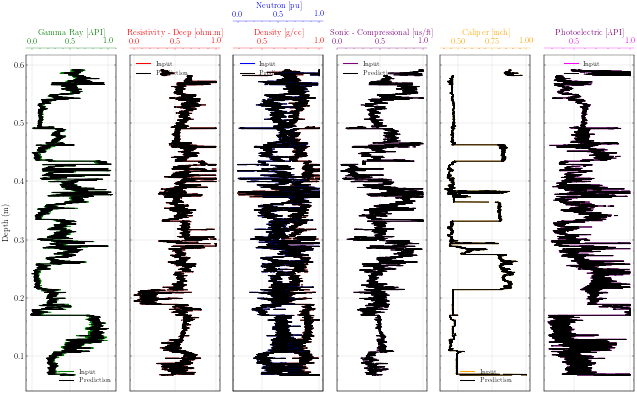

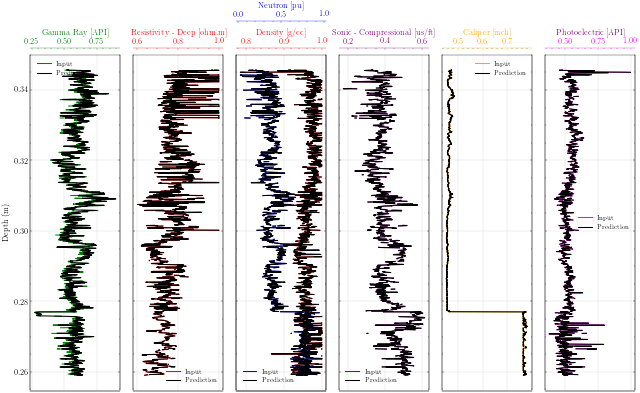

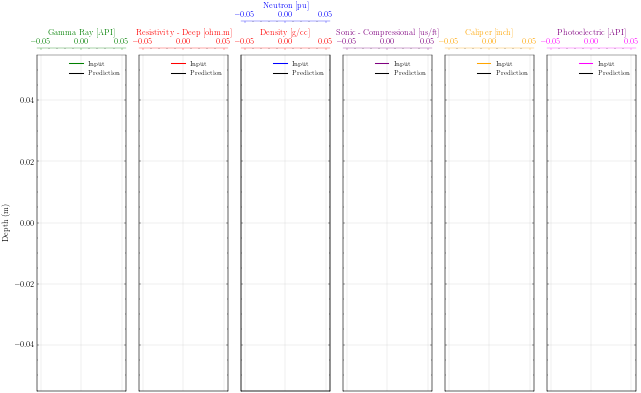

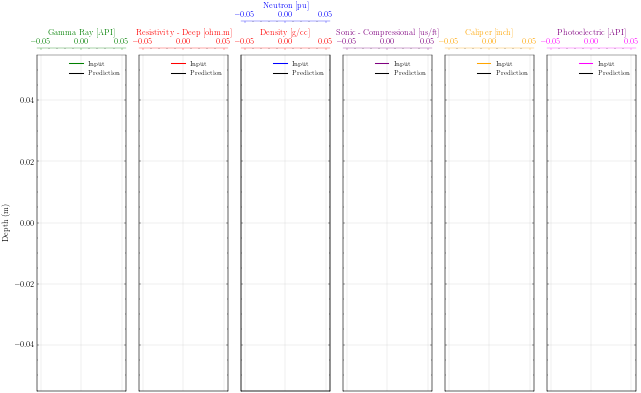

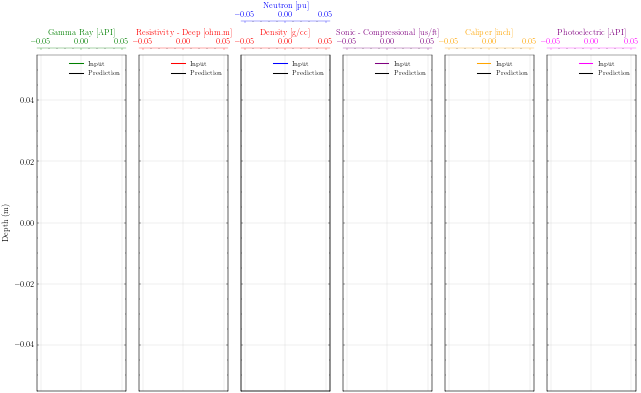

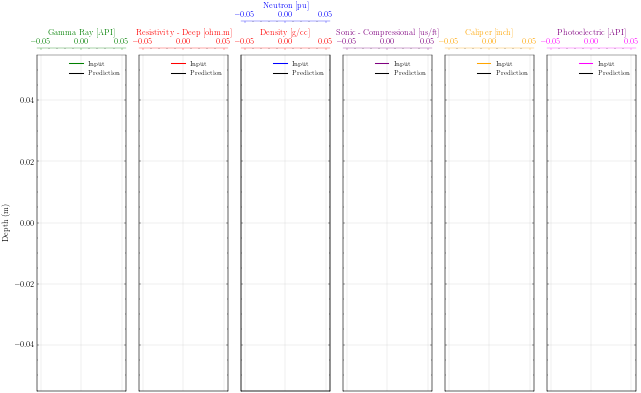

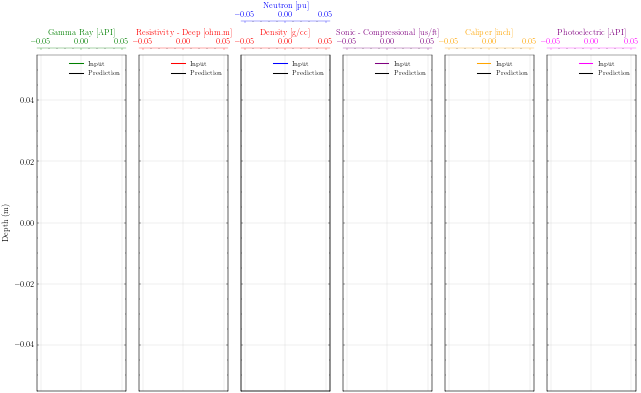

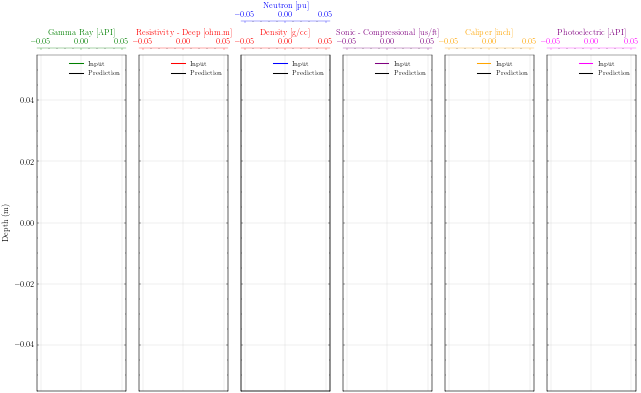

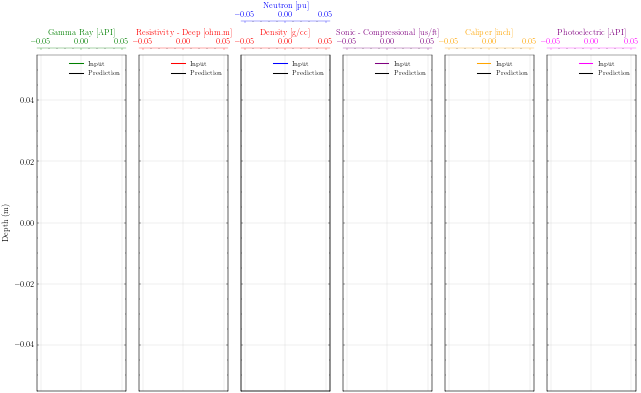

In [4]:
# ['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']

model_name = 'best'

input_train = np.load('./'+model_name+'/pretrain/input_train.npy')
input_valid = np.load('./'+model_name+'/pretrain/input_valid.npy')

pred_train = np.load('./'+model_name+'/pretrain/pred_train.npy')
pred_valid = np.load('./'+model_name+'/pretrain/pred_valid.npy')

mask_train = np.load('./'+model_name+'/pretrain/mask_train.npy')
mask_valid = np.load('./'+model_name+'/pretrain/mask_valid.npy')

mask_train_df = pd.DataFrame(mask_train.reshape(-1,1), columns=['MASK'])
mask_valid_df = pd.DataFrame(mask_valid.reshape(-1,1), columns=['MASK'])

input_train_df = pd.DataFrame(input_train.reshape(-1,7), columns=['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_train_df = (input_train_df * (1-mask_train_df.values) + mask_train_df.values*-999.25)
input_train_df = input_train_df.replace(-999.25, np.nan)
input_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
input_train_df['WELL'] = train_dataset.data['WELL']

pred_train_df = pd.DataFrame(pred_train.reshape(-1,7), columns=['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
pred_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
pred_train_df['WELL'] = train_dataset.data['WELL']

input_valid_df = pd.DataFrame(input_valid.reshape(-1,7), columns=['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_valid_df = (input_valid_df * (1-mask_valid_df.values) + mask_valid_df.values*-999.25)
input_valid_df = input_valid_df.replace(-999.25, np.nan)
input_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
input_valid_df['WELL'] = valid_dataset.data['WELL']

pred_valid_df = pd.DataFrame(pred_valid.reshape(-1,7), columns=['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
pred_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
pred_valid_df['WELL'] = valid_dataset.data['WELL']

train_well = np.unique(train_dataset.data['WELL'].values)
valid_well = np.unique(valid_dataset.data['WELL'].values)

for i in range(len(train_well)):
        if i % 10 == 0:
                df1 = input_train_df[input_train_df['WELL']==train_well[i]]
                df2 = pred_train_df[pred_train_df['WELL']==train_well[i]]
                plot_wirelines(df1, df2, label1='Input', label2='Prediction')
                plt.savefig(str(model_name)+'_pretrained_well_'+str(i)+'.png')

<e id=’fine_tune’></e>
# Validation: Fine-tuning

<e1 id=’dts_pred’></e1>
## DTS Prediction

In [ ]:
# ['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']

model_name = 'best'

input_train = np.load('./best/finetune/dtspred/input_dts_train.npy')
input_valid = np.load('./best/finetune/dtspred/input_dts_valid.npy')

pred_train = np.load('./best/finetune/dtspred/pred_dts_train.npy')
pred_valid = np.load('./best/finetune/dtspred/pred_dts_valid.npy')

['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']

input_train_df = pd.DataFrame(input_train.reshape(-1,7), columns=['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
input_train_df['WELL'] = train_dataset.data['WELL']
input_train_df['DTS'] = train_dataset.data['DTS']

pred_train_df = pd.DataFrame(pred_train.reshape(-1,1), columns=['DTS'])
pred_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
pred_train_df['WELL'] = train_dataset.data['WELL']

input_valid_df = pd.DataFrame(input_valid.reshape(-1,7), columns=['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
input_valid_df['WELL'] = valid_dataset.data['WELL']
input_valid_df['DTS'] = valid_dataset.data['DTS']

pred_valid_df = pd.DataFrame(pred_valid.reshape(-1,1), columns=['DTS'])
pred_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
pred_valid_df['WELL'] = valid_dataset.data['WELL']

train_well = np.unique(train_dataset.data['WELL'].values)
valid_well = np.unique(valid_dataset.data['WELL'].values)

print('Training')

for i in range(len(train_well)):
        if i % 5 == 0:
                df1 = input_train_df[input_train_df['WELL']==train_well[i]]
                df2 = pred_train_df[pred_train_df['WELL']==train_well[i]]
                plot_wirelines_dts(df1, df2, label1='Input', label2='Prediction')
                plt.savefig(str(model_name)+'_dts_train_well_'+str(i)+'.png')

print('Validation')

for i in range(len(valid_well)):
        if i % 2 == 0:
                df1 = input_valid_df[input_valid_df['WELL']==valid_well[i]]#.head(256)
                df2 = pred_valid_df[pred_valid_df['WELL']==valid_well[i]]#.head(256)
                plot_wirelines_dts(df1, df2, label1='Input', label2='Prediction')
                plt.savefig(str(model_name)+'_dts_valid_well_'+str(i)+'.png')

<e2 id=’zero_shot’></e2>
## Zero-shot Learning

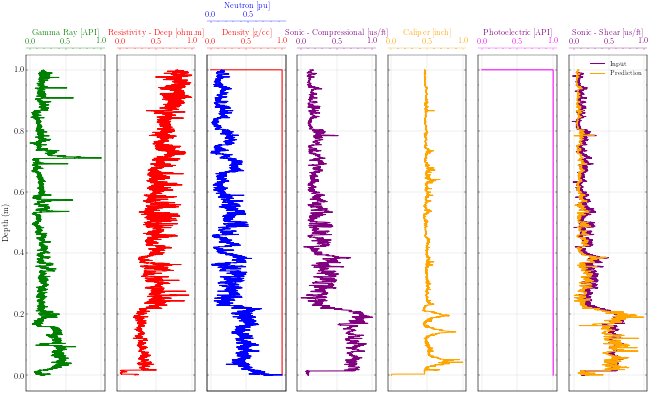

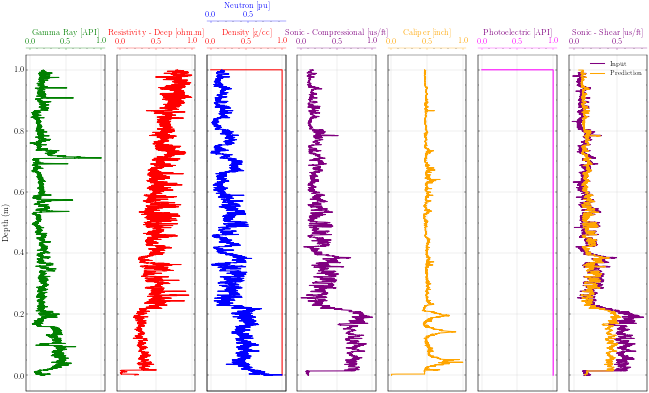

In [10]:
df = pd.read_csv('Well.csv')
df1 = df.copy()
df1['DTS'] = df['DTS_PRED'].copy()

df_nn = pd.DataFrame(np.load('NN_OOT.npy'), columns=['DTS'])
df_nn['DEPTH_MD'] = df1['DEPTH_MD'].copy()

df2 = df.copy()

plot_wirelines_dts(df1, df2, label1='Input', label2='Prediction')
plt.savefig(str(model_name)+'_dts_test_well_'+str(1)+'.png')

plot_wirelines_dts(df1, df_nn, label1='Input', label2='Prediction')
plt.savefig('NN'+'_dts_test_well_'+str(1)+'.png')

<e3 id=’facies_pred’></e3>
## FACIES Prediction

Training
Validation


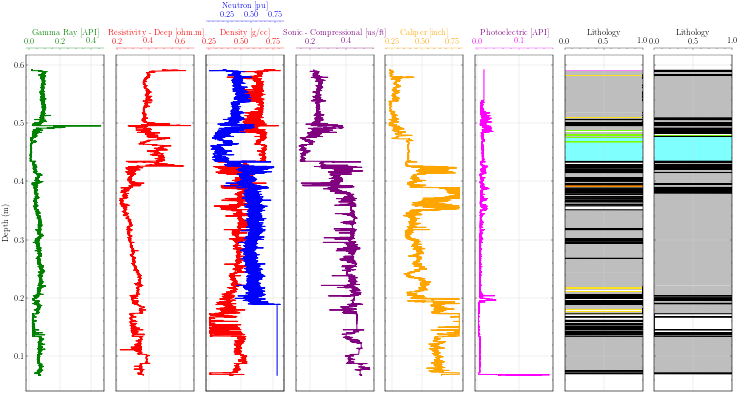

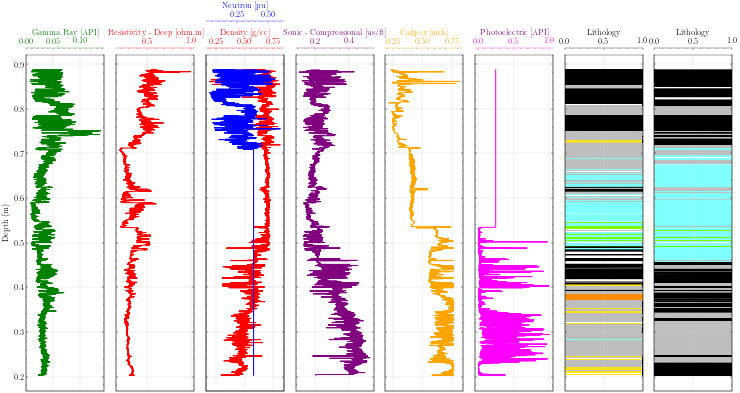

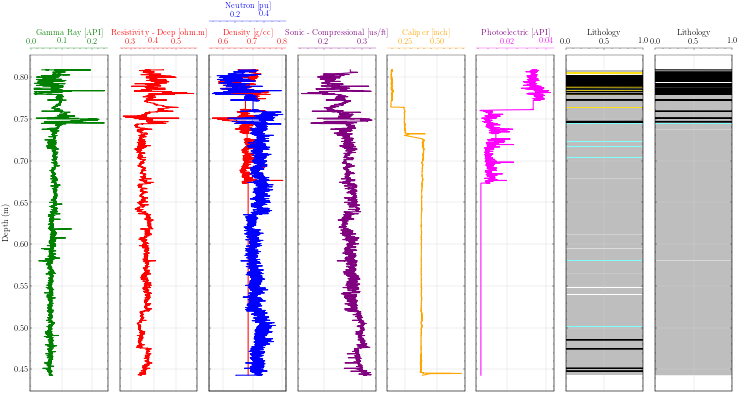

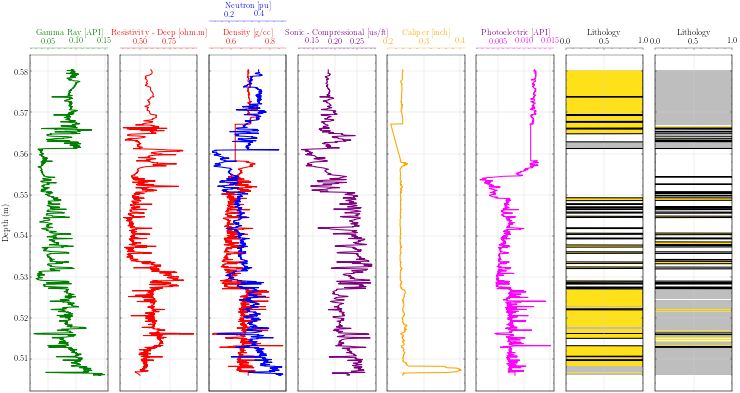

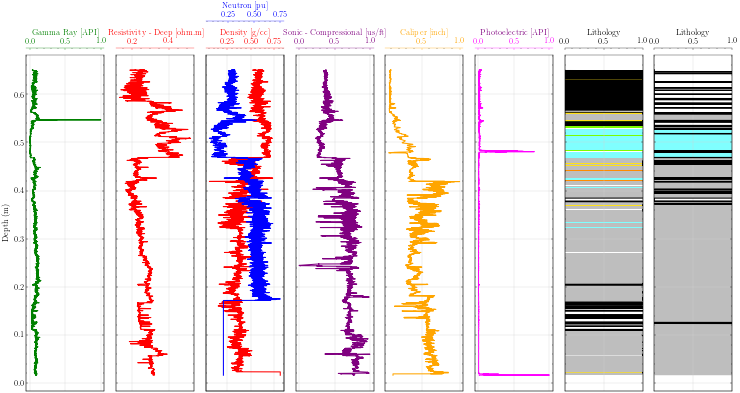

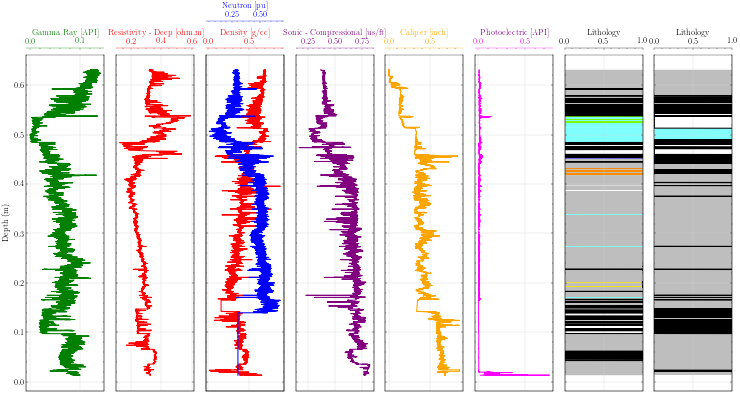

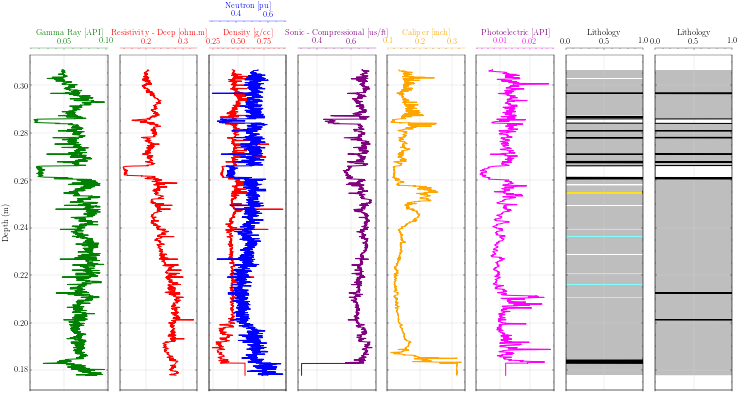

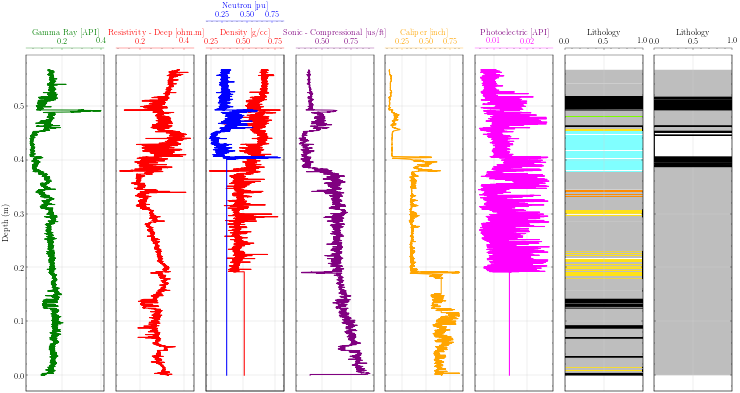

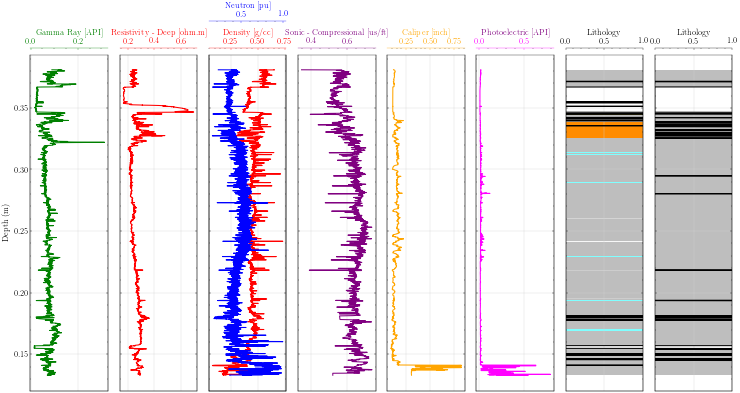

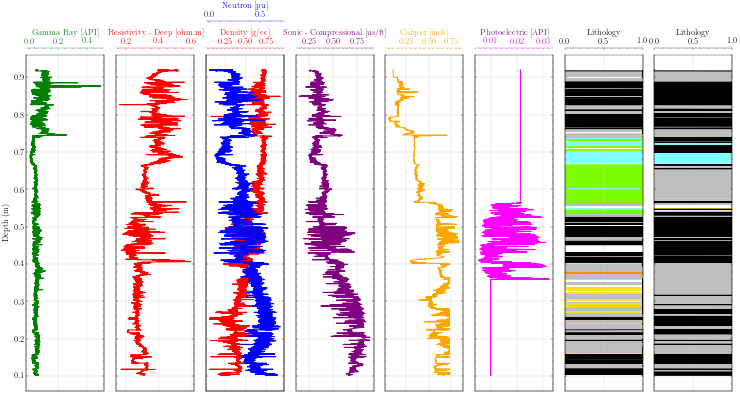

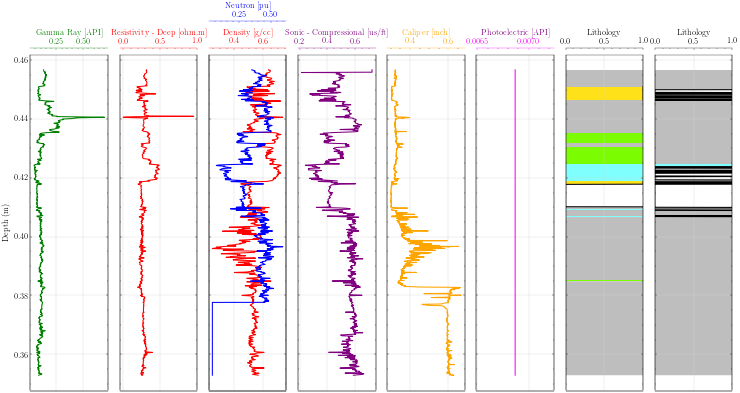

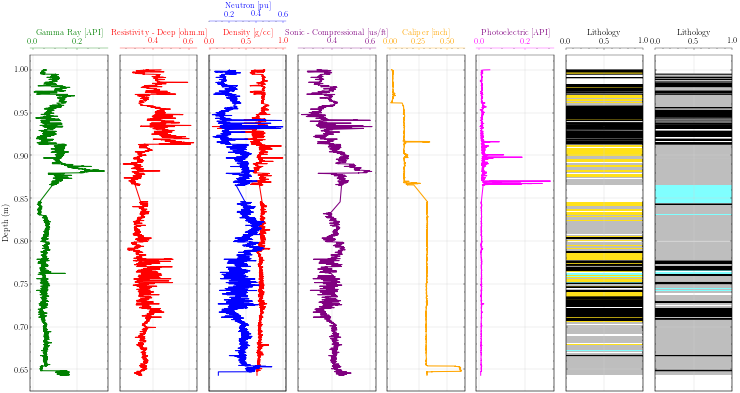

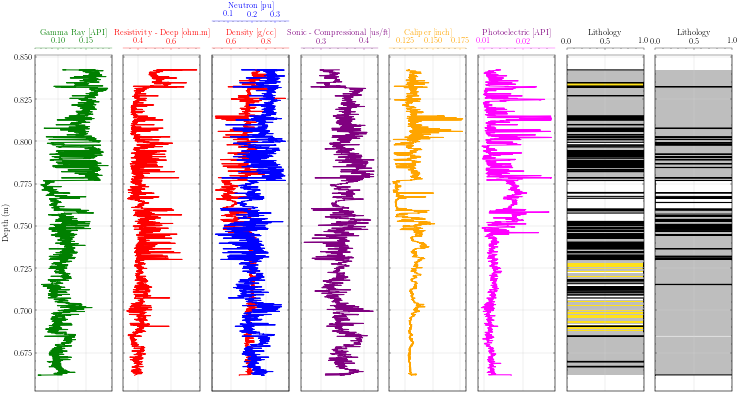

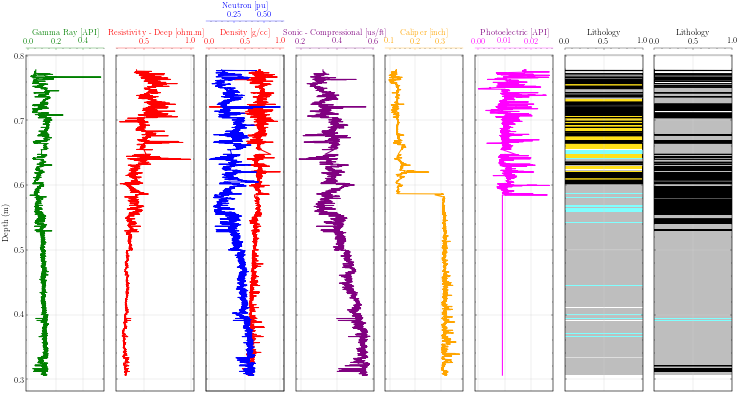

In [5]:
# ['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'facies', 'DTC']

# folder_dir = './best/'
folder_dir = './best/'
model_name = 'best'

lithology_numbers = {0: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 1: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 2: {'lith':'Shale', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 3: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 4: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 5: {'lith':'Limestone', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 6: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 7: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 8: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 9: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 10: {'lith':'Coal', 'lith_num':11, 'hatch':'', 'color':'black'},
                 11: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

input_train = np.load(folder_dir+'finetune/faciespred/input_facies_train.npy')
input_valid = np.load(folder_dir+'finetune/faciespred/input_facies_valid.npy')

pred_train = np.load('./best/finetune/faciespred/pred_facies_train.npy')
pred_valid = np.load('./best/finetune/faciespred/pred_facies_valid.npy')

# ['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']
# input_train_df = pd.DataFrame(input_train.reshape(-1,7), columns=['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])

input_train_df = pd.DataFrame(input_train.reshape(-1,7), columns=['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
input_train_df['WELL'] = train_dataset.data['WELL']
input_train_df['FACIES'] = train_dataset.data['FORCE_2020_LITHOFACIES_LITHOLOGY']

pred_train_df = pd.DataFrame(pred_train.reshape(-1,1), columns=['FACIES'])
pred_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
pred_train_df['WELL'] = train_dataset.data['WELL']

input_valid_df = pd.DataFrame(input_valid.reshape(-1,7), columns=['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
input_valid_df['WELL'] = valid_dataset.data['WELL']
input_valid_df['FACIES'] = valid_dataset.data['FORCE_2020_LITHOFACIES_LITHOLOGY']

pred_valid_df = pd.DataFrame(pred_valid.reshape(-1,1), columns=['FACIES'])
pred_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
pred_valid_df['WELL'] = valid_dataset.data['WELL']

train_well = np.unique(train_dataset.data['WELL'].values)
valid_well = np.unique(valid_dataset.data['WELL'].values)

print('Training')

for i in range(len(train_well)):
        if i % 25 == 0:
                df1 = input_train_df[input_train_df['WELL']==train_well[i]]
                df2 = pred_train_df[pred_train_df['WELL']==train_well[i]]
                plot_wirelines_facies(df1, df2)
                plt.savefig(str(model_name)+'_facies_train_well_'+str(i)+'.png')

print('Validation')

for i in range(len(valid_well)):
        if i % 1 == 0:
                df1 = input_valid_df[input_valid_df['WELL']==valid_well[i]]#.head(256)
                df2 = pred_valid_df[pred_valid_df['WELL']==valid_well[i]]#.head(256)
                plot_wirelines_facies(df1, df2, label1='Input', label2='Prediction')
                plt.savefig(str(model_name)+'_facies_valid_well_'+str(i)+'.png')

In [ ]:
train